## Defining necessary functions

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
import matplotlib.image as mpimg
from skimage.feature import hog
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
import cv2
import sys

# Define a function to return HOG features and visualization
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a function to return HOG features and visualization
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    total_len_imag = len(imgs)
    counter = 0
    count = 0
    for file in imgs:
        file_features = []
        counter += 1
        if (counter+1) % (total_len_imag//4) == 0:
            count += 1
            print ("Features of " + str(count) + " quarter has been extracted" )
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

## HOG features, binned color, histograms of color with SVM

In [3]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images    
    
# Read in cars and notcars
images_car = glob.glob('vehicles/GTI_Far/*.png')
images_car += glob.glob('vehicles/GTI_Left/*.png')
images_car += glob.glob('vehicles/GTI_MiddleClose/*.png')
images_car += glob.glob('vehicles/GTI_Right/*.png')
images_car += glob.glob('vehicles/KITTI_extracted/*.png')
images_notcar = glob.glob('non-vehicles/Extras/*.png')
images_notcar += glob.glob('non-vehicles/GTI/*.png')
cars = []
notcars = []
for image in images_car:
        cars.append(image)
for image in images_notcar:
        notcars.append(image)
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (10, 10) # Spatial binning dimensions
hist_bins = 60    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 700] # Min and max in y to search in slide_window()

print ("Extracting Car Features ...")
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ("Extracting NotCar Features ...")
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample


Extracting Car Features ...


/Users/Rouzbeh/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Features of 1 quarter has been extracted
Features of 2 quarter has been extracted
Features of 3 quarter has been extracted
Features of 4 quarter has been extracted
Extracting NotCar Features ...
Features of 1 quarter has been extracted
Features of 2 quarter has been extracted
Features of 3 quarter has been extracted
Features of 4 quarter has been extracted
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5772
20.45 Seconds to train SVC...
Test Accuracy of SVC =  0.9958


## Testing the model

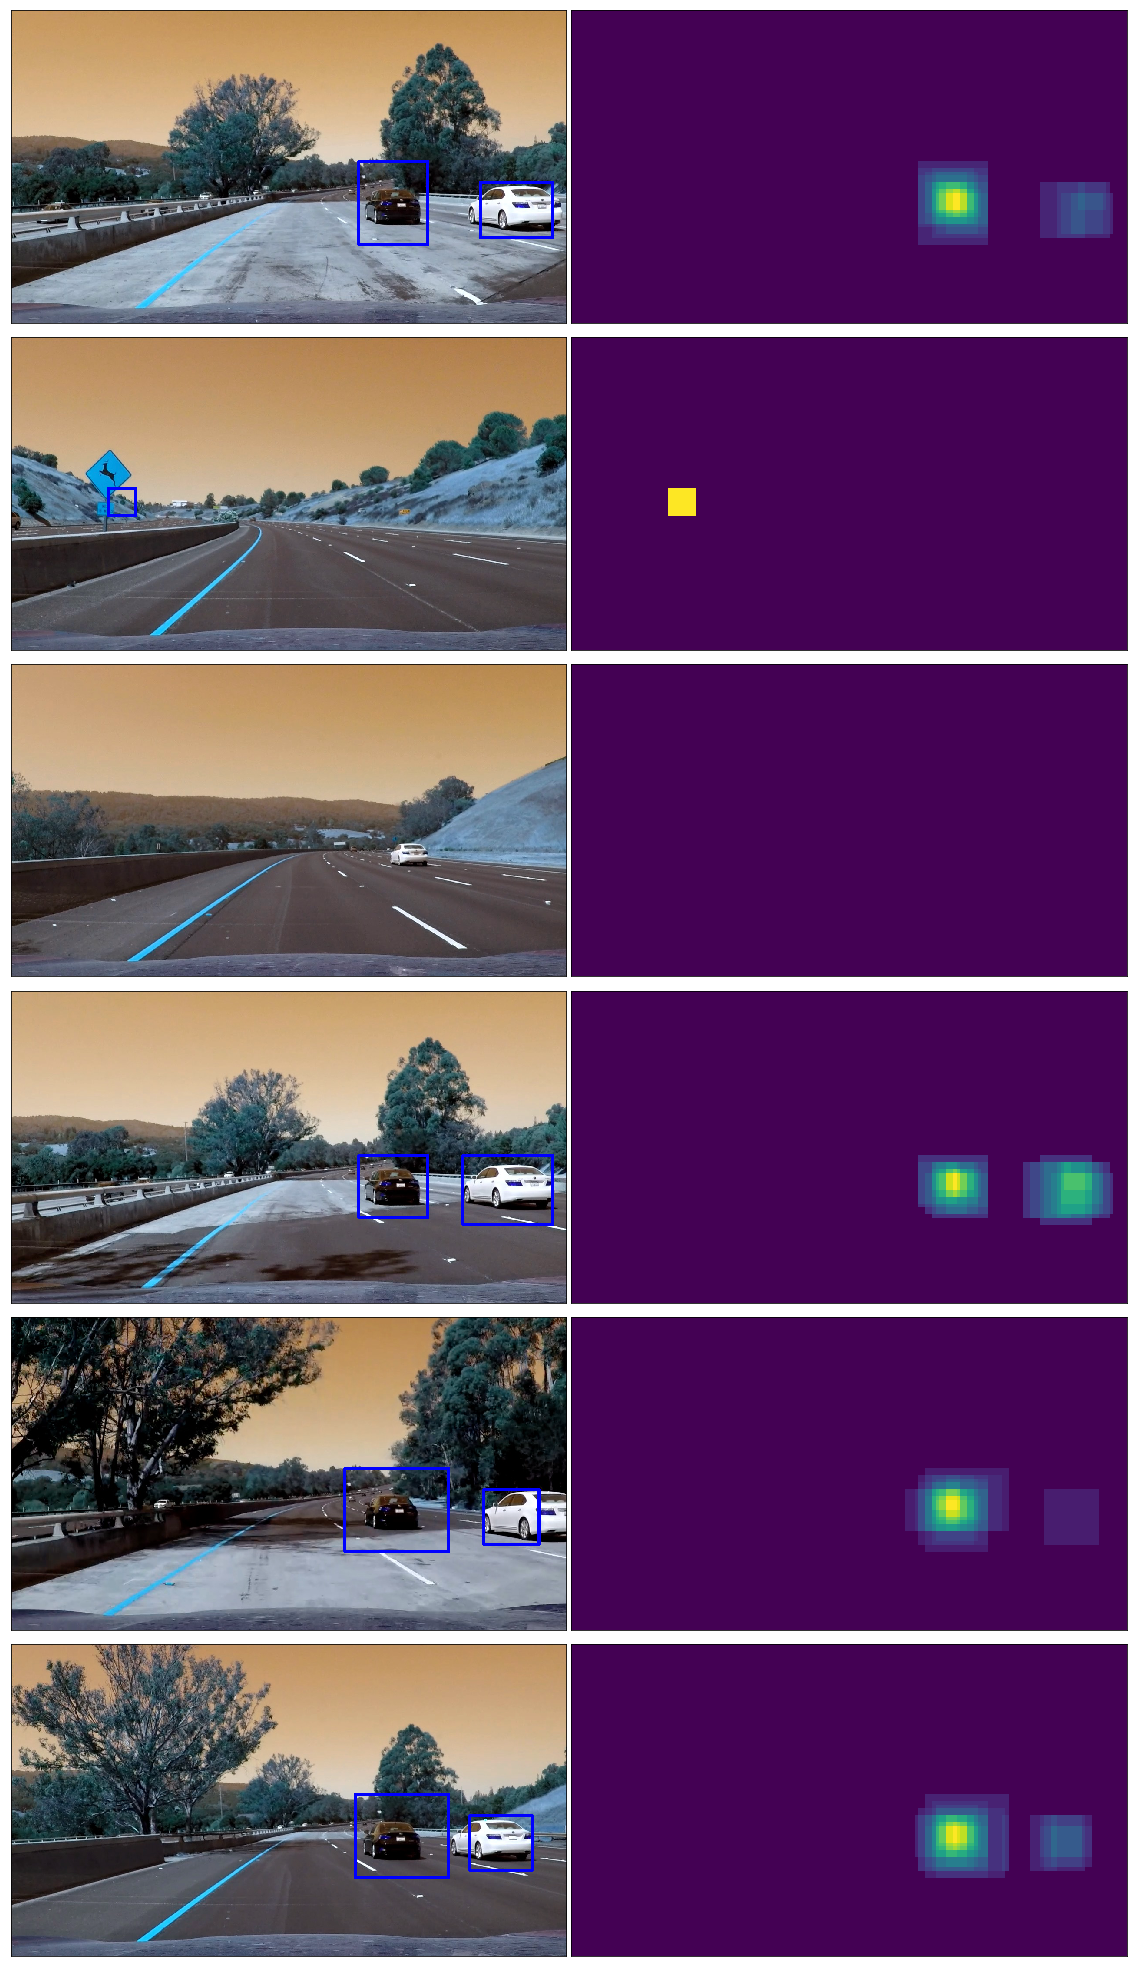

In [95]:
# img = cv2.imread('test_images/test6.jpg')
class Variable:
    def __init__(self, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
        self.ystart = ystart
        self.ystop = ystop
        self.scale = scale
        self.svc = svc
        self.X_scaler = X_scaler
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
ystart = 400
ystop = 656
scale = 1.5
count_ = 0
variables = Variable(ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# Define a single function that can extract features using hog sub-sampling and make predictions
labels = None
def find_cars(img):
    global count_, labels
    if count_ % 2 == 0:
        hot_windows = []
        draw_img = np.copy(img)
    #     img = img.astype(np.float32)/255

        img_tosearch = img[variables.ystart:variables.ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if variables.scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/variables.scale), np.int(imshape[0]/variables.scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // variables.pix_per_cell) - variables.cell_per_block + 1
        nyblocks = (ch1.shape[0] // variables.pix_per_cell) - variables.cell_per_block + 1 
        nfeat_per_block = variables.orient*variables.cell_per_block**2

        # 64 was the original sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // variables.pix_per_cell) - variables.cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, variables.orient, variables.pix_per_cell, variables.cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, variables.orient, variables.pix_per_cell, variables.cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, variables.orient, variables.pix_per_cell, variables.cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*variables.pix_per_cell
                ytop = ypos*variables.pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=variables.spatial_size)
                hist_features = color_hist(subimg, nbins=variables.hist_bins)

                # Scale features and make a prediction
                test_features = variables.X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = variables.X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = variables.svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*variables.scale)
                    ytop_draw = np.int(ytop*variables.scale)
                    win_draw = np.int(window*variables.scale)
    #                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    hot_windows.append(((xbox_left, ytop_draw+variables.ystart),(xbox_left+win_draw,ytop_draw+win_draw+variables.ystart)))
        
    return hot_windows
    
def pick_windows(img, hot_windows):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying 
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heatmap
    
fig = plt.figure(figsize=(20, 36))
i = 1
# we considerng 8 different combinations
for img in glob.glob("test_images/*.jpg"):
    img = cv2.imread(img)
    # Case 1
    variables.ystart = 300
    variables.ystop = 500
    variables.scale = 1.0
    hot_windows = find_cars(img)
    # Case 2
    variables.ystart = 400
    variables.ystop = 464
    variables.scale = 1.0
    hot_windows += find_cars(img)
    # Case 22
    variables.ystart = 300
    variables.ystop = 464
    variables.scale = 1.0
    hot_windows += find_cars(img)
    # Case222
    variables.ystart = 416
    variables.ystop = 480
    variables.scale = 1.0
    hot_windows += find_cars(img)
    # Case2222
    variables.ystart = 300
    variables.ystop = 550
    variables.scale = 1.5
    hot_windows += find_cars(img)
    # Case 3
    variables.ystart = 300
    variables.ystop = 600
    variables.scale = 2.0
    hot_windows += find_cars(img)
    # Case 4
    variables.ystart = 300
    variables.ystop = 700
    variables.scale = 2.5
    hot_windows += find_cars(img)
    # Case 5
    variables.ystart = 300
    variables.ystop = 700
    variables.scale = 3.
    hot_windows += find_cars(img)
    # Case 5
    variables.ystart = 300
    variables.ystop = 700
    variables.scale = 3.5
    hot_windows += find_cars(img)
    out_img, heatmap = pick_windows(img, hot_windows)
    ax = fig.add_subplot(6,2,i)
    i += 1
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.imshow(out_img)
    ax = fig.add_subplot(6,2,i)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.imshow(heatmap)
    i+=1
    cv2.imwrite("output_images/test_image"+str(i//2)+".jpg",out_img)
plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.show()

## Creating pipeline for the video files

In [91]:
# img = cv2.imread('test_images/test6.jpg')
# For this section I got some help from https://github.com/jeremy-shannon/CarND-Vehicle-Detection/blob/master/vehicle_detection_project.ipynb
##
class Variable:
    def __init__(self, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
        self.ystart = ystart
        self.ystop = ystop
        self.scale = scale
        self.svc = svc
        self.X_scaler = X_scaler
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
ystart = 400
ystop = 656
scale = 1.5
variables = Variable(ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# Define a single function that can extract features using hog sub-sampling and make predictions

class Video_Frames():
    def __init__(self):
        self.prev_windows = [] 
        
    def frame_stack(self, window):
        self.prev_windows.append(window)
        if len(self.prev_windows) > 13:
            self.prev_windows = self.prev_windows[len(self.prev_windows)-13:]


def find_cars(img):
    hot_windows = []
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255

    img_tosearch = img[variables.ystart:variables.ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if variables.scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/variables.scale), np.int(imshape[0]/variables.scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // variables.pix_per_cell) - variables.cell_per_block + 1
    nyblocks = (ch1.shape[0] // variables.pix_per_cell) - variables.cell_per_block + 1 
    nfeat_per_block = variables.orient*variables.cell_per_block**2

    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // variables.pix_per_cell) - variables.cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, variables.orient, variables.pix_per_cell, variables.cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, variables.orient, variables.pix_per_cell, variables.cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, variables.orient, variables.pix_per_cell, variables.cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*variables.pix_per_cell
            ytop = ypos*variables.pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=variables.spatial_size)
            hist_features = color_hist(subimg, nbins=variables.hist_bins)

            # Scale features and make a prediction
            test_features = variables.X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = variables.X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = variables.svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*variables.scale)
                ytop_draw = np.int(ytop*variables.scale)
                win_draw = np.int(window*variables.scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                hot_windows.append(((xbox_left, ytop_draw+variables.ystart),(xbox_left+win_draw,ytop_draw+win_draw+variables.ystart)))

    return hot_windows
    
def pick_windows(img, hot_windows):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying 
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heatmap
def capture_perframe(frame):
    img = frame
    # Case 1
    variables.ystart = 300
    variables.ystop = 450
    variables.scale = 1.0
    hot_windows = find_cars(img)
    # Case 2
    variables.ystart = 416
    variables.ystop = 480
    variables.scale = 1.0
    hot_windows += find_cars(img)
    # Case 3
    variables.ystart = 400
    variables.ystop = 496
    variables.scale = 1.5
    hot_windows += find_cars(img)
    # Case 4
    variables.ystart = 432
    variables.ystop = 528
    variables.scale = 1.5
    hot_windows += find_cars(img)
    # Case 5
    variables.ystart = 400
    variables.ystop = 528
    variables.scale = 2.0
    hot_windows += find_cars(img)
    # Case 6
    variables.ystart = 400
    variables.ystop = 560
    variables.scale = 2.0
    hot_windows += find_cars(img)
    # Case 7
    variables.ystart = 432
    variables.ystop = 596
    variables.scale = 3.5
    hot_windows += find_cars(img)
    # Case 8
    variables.ystart = 464
    variables.ystop = 660
    variables.scale = 3.5
    hot_windows += find_cars(img)

    
    if len(hot_windows) > 0:
        video_class.frame_stack(hot_windows)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rects in video_class.prev_windows:
        heatmap_img = add_heat(heatmap_img, rects)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(video_class.prev_windows)//2)
     
    labels = label(heatmap_img)
    draw_img= draw_labeled_bboxes(np.copy(img), labels)
    
#     out_img, heatmap = pick_windows(img, hot_windows)
    
    return draw_img


## Result on the test video file

In [93]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
yellow_output = 'test_video_out.mp4'
video_class = Video_Frames()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_video.mp4')
yellow_clip = clip2.fl_image(capture_perframe)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:32<00:00,  1.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 31 s, sys: 1.28 s, total: 32.3 s
Wall time: 34.3 s


## Result on the project video file

In [94]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
yellow_output = 'project_video_out.mp4'
video_class = Video_Frames()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(capture_perframe)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [18:44<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 17min 30s, sys: 42.2 s, total: 18min 12s
Wall time: 18min 45s
